In [1]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import os
import tensorflow as tf
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

from tensorflow.keras import Sequential, Input, Model, callbacks
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import (BinaryAccuracy, Precision, Recall, AUC, 
                                      FalsePositives, FalseNegatives, TruePositives, TrueNegatives)

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# folder_var = 'data1/train/malignant/'
# folder_yok = 'data1/train/benign/'
# folder_test_var = 'data1/test/malignant/'
# folder_test_yok = 'data1/test/benign/'

folder_train = 'data1/train/'
folder_validation = 'data1/validation/'
folder_test = 'data1/test/'

In [4]:
directory_list = list()
for root, dirs, files in os.walk('data1/', topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))

# print (directory_list)

def load_images_from_folder(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            i = 0
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)
                print ("Deleting: %s" % (path))
                if os.remove(path):
                    print ("Unable to delete!")
                else:
                    print ("Deleted...")
                    i += 1
                print("Files Deleted: %d" % (i))

for folder in directory_list:
    load_images_from_folder(folder)

In [5]:
def num_of_files(folder):
    num_of_files = 0
    for root, dirs, files in os.walk(folder, topdown=False):
        num_of_files += len(files)
    return num_of_files
        
num_of_files_train = num_of_files(folder_train)
num_of_files_validation = num_of_files(folder_validation)
num_of_files_test = num_of_files(folder_test)

In [6]:
img_height = img_width = 28
batch_size = 20

##################

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
#     horizontal_flip=True,
#     vertical_flip=True,
#     data_format="channels_last",
#     dtype=tf.float32,
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)

##################

train_gen = train_datagen.flow_from_directory(
    folder_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

validation_gen = validation_datagen.flow_from_directory(
    folder_validation,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

test_gen = test_datagen.flow_from_directory(
    folder_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

Found 1300 images belonging to 2 classes.
Found 245 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [ ]:
# model = Sequential(
#     [
#         Input(shape=(28, 28, 3)),    
#         Conv2D(32, 3, padding="valid", activation="relu"),
#         BatchNormalization(),
#         MaxPooling2D(),
#         Conv2D(64, 3, activation="relu"),
#         BatchNormalization(),
# #         relu,
#         MaxPooling2D(),
#         Conv2D(128, 3, activation="relu"),
#         BatchNormalization(),
# #         relu,
#         Flatten(),
#         Dense(64, activation="relu"),
#         Dense(1, activation="sigmoid"),
#     ])
# print(model.summary())

In [ ]:
# import tensorflow_hub as hub

# model = Sequential([
#     hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
#                    trainable=False),  # Can be True, see below.
#     Dense(1, activation='softmax')
# ])
# model.build([None, 224, 224, 3])  # Batch input shape

In [ ]:
# model.compile(
#     loss=BinaryCrossentropy(from_logits=True),
#     optimizer=Adam(lr=3e-4),
#     metrics=['accuracy'],)

In [7]:
inputs = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, 3)(inputs)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [8]:
METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

In [9]:
history = model.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=num_of_files_train // batch_size,
    validation_data=validation_gen,
    validation_steps=num_of_files_validation // batch_size,
)

Epoch 1/30
65/65 [==============================] - 11s 150ms/step - loss: 0.6418 - tp: 10.3333 - tn: 473.7576 - fp: 32.4242 - fn: 153.1818 - precision: 0.2262 - recall: 0.0801 - acc: 0.6970 - auc: 0.5580 - val_loss: 0.5171 - val_tp: 0.0000e+00 - val_tn: 196.0000 - val_fp: 0.0000e+00 - val_fn: 44.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8167 - val_auc: 0.4648
Epoch 2/30
65/65 [==============================] - 9s 139ms/step - loss: 0.4743 - tp: 5.1970 - tn: 511.3788 - fp: 5.2121 - fn: 147.9091 - precision: 0.6323 - recall: 0.0341 - acc: 0.7841 - auc: 0.7047 - val_loss: 0.5570 - val_tp: 0.0000e+00 - val_tn: 197.0000 - val_fp: 0.0000e+00 - val_fn: 43.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8208 - val_auc: 0.6066
Epoch 3/30
65/65 [==============================] - 9s 140ms/step - loss: 0.4788 - tp: 22.0303 - tn: 506.4091 - fp: 10.0455 - fn: 131.2121 - precision: 0.7050 - recall: 0.1471 - acc: 0.7964 - auc: 0.7083 - val_loss: 0.4

Epoch 23/30
65/65 [==============================] - 9s 139ms/step - loss: 0.1279 - tp: 137.5455 - tn: 500.5000 - fp: 14.9091 - fn: 16.7424 - precision: 0.9064 - recall: 0.8950 - acc: 0.9543 - auc: 0.9858 - val_loss: 0.7737 - val_tp: 10.0000 - val_tn: 165.0000 - val_fp: 30.0000 - val_fn: 35.0000 - val_precision: 0.2500 - val_recall: 0.2222 - val_acc: 0.7292 - val_auc: 0.6348
Epoch 24/30
65/65 [==============================] - 9s 139ms/step - loss: 0.0968 - tp: 146.1970 - tn: 506.1364 - fp: 7.1515 - fn: 10.2121 - precision: 0.9536 - recall: 0.9395 - acc: 0.9754 - auc: 0.9919 - val_loss: 0.7974 - val_tp: 11.0000 - val_tn: 174.0000 - val_fp: 23.0000 - val_fn: 32.0000 - val_precision: 0.3235 - val_recall: 0.2558 - val_acc: 0.7708 - val_auc: 0.6175
Epoch 25/30
65/65 [==============================] - 9s 139ms/step - loss: 0.0930 - tp: 130.7121 - tn: 513.9697 - fp: 9.9848 - fn: 15.0303 - precision: 0.9399 - recall: 0.9023 - acc: 0.9668 - auc: 0.9923 - val_loss: 1.2284 - val_tp: 25.0000 - va

In [10]:
result = model.evaluate(test_gen)

18/18 [==============================] - 2s 123ms/step - loss: 0.7909 - tp: 15.0000 - tn: 272.0000 - fp: 28.0000 - fn: 35.0000 - precision: 0.3488 - recall: 0.3000 - acc: 0.8200 - auc: 0.6413


In [11]:
((result[1]+result[2]) / num_of_files_test) * 100

82.0

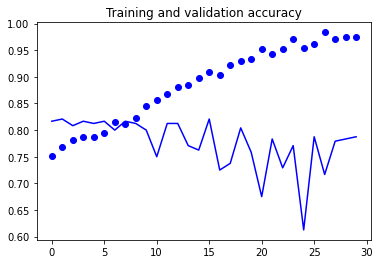

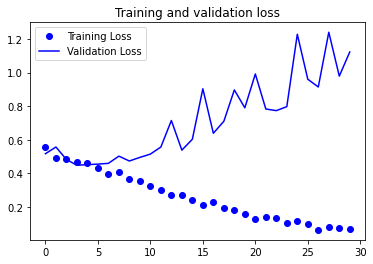

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.

width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

shear_range is for randomly applying shearing transformations.

zoom_range is for randomly zooming inside pictures.

horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).

fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [24]:
img_height = img_width = 28
batch_size = 20

##################

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

'''
- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to 
randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when 
there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation 
or a width/height shift.
'''

validation_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)

##################

train_gen = train_datagen.flow_from_directory(
    folder_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

validation_gen = validation_datagen.flow_from_directory(
    folder_validation,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

test_gen = test_datagen.flow_from_directory(
    folder_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

##################

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# inputs = Input(shape=(img_height, img_width, 3))
# x = Conv2D(32, 3)(inputs)
# x = BatchNormalization()(x)
# x = relu(x)
# x = MaxPooling2D()(x)
# x = Conv2D(64, 3)(x)
# x = BatchNormalization()(x)
# x = relu(x)
# x = MaxPooling2D()(x)
# x = Conv2D(128, 3)(x)
# x = BatchNormalization()(x)
# x = relu(x)
# x = Dropout(0.5)
# x = Flatten()(x)
# x = Dense(64, activation="relu")(x)
# outputs = Dense(1, activation="sigmoid")(x)
# model = Model(inputs=inputs, outputs=outputs)

##################

METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

history = model.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=num_of_files_train // batch_size,
    validation_data=validation_gen,
    validation_steps=num_of_files_validation // batch_size,
)

Found 1300 images belonging to 2 classes.
Found 245 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Epoch 1/30
65/65 [==============================] - 11s 154ms/step - loss: 0.6985 - tp: 22.7576 - tn: 456.2879 - fp: 62.9697 - fn: 127.6818 - precision: 0.2709 - recall: 0.1700 - acc: 0.7196 - auc: 0.5395 - val_loss: 0.6094 - val_tp: 0.0000e+00 - val_tn: 196.0000 - val_fp: 0.0000e+00 - val_fn: 44.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8167 - val_auc: 0.6175
Epoch 2/30
65/65 [==============================] - 10s 151ms/step - loss: 0.5853 - tp: 14.3333 - tn: 478.0606 - fp: 36.6364 - fn: 140.6667 - precision: 0.2767 - recall: 0.0860 - acc: 0.7316 - auc: 0.5610 - val_loss: 0.4892 - val_tp: 0.0000e+00 - val_tn: 197.0000 - val_fp: 0.0000e+00 - val_fn: 43.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8208 - val_auc: 0.6493
Epoch 3/30
65/65 [==============================] - 10s 147ms/step - loss: 0.5757 - tp: 13.7

65/65 [==============================] - 9s 140ms/step - loss: 0.5371 - tp: 6.1061 - tn: 505.0909 - fp: 3.4697 - fn: 155.0303 - precision: 0.6733 - recall: 0.0401 - acc: 0.7637 - auc: 0.6261 - val_loss: 0.5486 - val_tp: 7.0000 - val_tn: 185.0000 - val_fp: 11.0000 - val_fn: 37.0000 - val_precision: 0.3889 - val_recall: 0.1591 - val_acc: 0.8000 - val_auc: 0.5927
Epoch 23/30
65/65 [==============================] - 9s 143ms/step - loss: 0.5233 - tp: 5.5909 - tn: 509.0606 - fp: 4.1818 - fn: 150.8636 - precision: 0.6181 - recall: 0.0381 - acc: 0.7709 - auc: 0.6239 - val_loss: 0.4865 - val_tp: 4.0000 - val_tn: 187.0000 - val_fp: 8.0000 - val_fn: 41.0000 - val_precision: 0.3333 - val_recall: 0.0889 - val_acc: 0.7958 - val_auc: 0.6677
Epoch 24/30
65/65 [==============================] - 9s 144ms/step - loss: 0.5090 - tp: 6.0303 - tn: 517.7273 - fp: 1.0455 - fn: 144.8939 - precision: 0.9072 - recall: 0.0420 - acc: 0.7842 - auc: 0.6332 - val_loss: 0.5023 - val_tp: 9.0000 - val_tn: 185.0000 - val

In [25]:
result = model.evaluate(test_gen)
((result[1]+result[2]) / num_of_files_test) * 100

18/18 [==============================] - 2s 119ms/step - loss: 0.5093 - tp: 4.0000 - tn: 293.0000 - fp: 7.0000 - fn: 46.0000 - precision: 0.3636 - recall: 0.0800 - acc: 0.8486 - auc: 0.5973


84.85714285714285

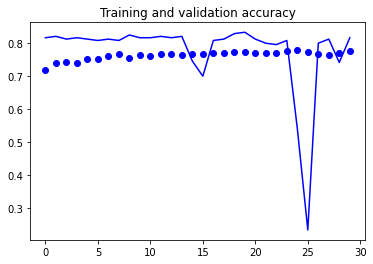

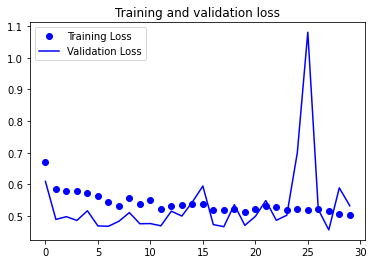

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
folder_test_teknofest = 'data2/test/'
num_of_files_test_2 = num_of_files(folder_test_teknofest)

test_gen_teknofest = test_datagen.flow_from_directory(
    'data2/test/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

result_tf = model.evaluate(test_gen_teknofest)
((result_tf[1]+result_tf[2]) / num_of_files_test_2) * 100

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 139ms/step - loss: 0.5034 - tp: 2.0000 - tn: 13.0000 - fp: 1.0000 - fn: 4.0000 - precision: 0.6667 - recall: 0.3333 - acc: 0.7500 - auc: 0.7857


71.42857142857143

In [30]:
folder_train = 'data/train/'
folder_validation = 'data/validation/'
folder_test = 'data/test/'

img_height = img_width = 28
batch_size = 20

##################

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)

##################

train_gen = train_datagen.flow_from_directory(
    folder_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

validation_gen = validation_datagen.flow_from_directory(
    folder_validation,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

test_gen = test_datagen.flow_from_directory(
    folder_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

##################

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

##################

METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

history = model.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=num_of_files_train // batch_size,
    validation_data=validation_gen,
    validation_steps=num_of_files_validation // batch_size,
)

Found 20225 images belonging to 2 classes.
Found 2551 images belonging to 2 classes.
Found 2555 images belonging to 2 classes.
Epoch 1/30
65/65 [==============================] - 15s 213ms/step - loss: 0.6062 - tp: 21.1818 - tn: 477.4091 - fp: 46.4848 - fn: 124.6212 - precision: 0.2837 - recall: 0.1419 - acc: 0.7336 - auc: 0.5578 - val_loss: 0.5038 - val_tp: 0.0000e+00 - val_tn: 196.0000 - val_fp: 0.0000e+00 - val_fn: 44.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8167 - val_auc: 0.5833
Epoch 2/30
65/65 [==============================] - 13s 201ms/step - loss: 0.5350 - tp: 12.2576 - tn: 509.6061 - fp: 31.9242 - fn: 115.9091 - precision: 0.2821 - recall: 0.1009 - acc: 0.7824 - auc: 0.5845 - val_loss: 0.4775 - val_tp: 0.0000e+00 - val_tn: 195.0000 - val_fp: 0.0000e+00 - val_fn: 45.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8125 - val_auc: 0.7476
Epoch 3/30
65/65 [==============================] - 13s 201ms/step - loss: 0.5293 - tp: 8

65/65 [==============================] - 13s 199ms/step - loss: 0.4380 - tp: 11.9545 - tn: 544.6515 - fp: 10.1818 - fn: 102.9091 - precision: 0.5590 - recall: 0.1165 - acc: 0.8271 - auc: 0.6854 - val_loss: 0.4272 - val_tp: 13.0000 - val_tn: 195.0000 - val_fp: 4.0000 - val_fn: 28.0000 - val_precision: 0.7647 - val_recall: 0.3171 - val_acc: 0.8667 - val_auc: 0.7225
Epoch 23/30
65/65 [==============================] - 13s 204ms/step - loss: 0.4471 - tp: 10.4394 - tn: 539.0000 - fp: 10.6212 - fn: 109.6364 - precision: 0.4584 - recall: 0.0772 - acc: 0.8145 - auc: 0.6960 - val_loss: 0.4040 - val_tp: 9.0000 - val_tn: 194.0000 - val_fp: 4.0000 - val_fn: 33.0000 - val_precision: 0.6923 - val_recall: 0.2143 - val_acc: 0.8458 - val_auc: 0.7585
Epoch 24/30
65/65 [==============================] - 13s 199ms/step - loss: 0.4252 - tp: 10.2727 - tn: 540.5455 - fp: 10.4394 - fn: 108.4394 - precision: 0.4586 - recall: 0.0761 - acc: 0.8191 - auc: 0.7311 - val_loss: 0.4172 - val_tp: 9.0000 - val_tn: 192.0

In [35]:
folder_test = 'data/test/'
result = model.evaluate(test_gen)
        
num_of_files_test = num_of_files(folder_test)
((result[1]+result[2]) / num_of_files_test) * 100

128/128 [==============================] - 21s 160ms/step - loss: 0.4230 - tp: 78.0000 - tn: 2060.0000 - fp: 44.0000 - fn: 373.0000 - precision: 0.6393 - recall: 0.1729 - acc: 0.8368 - auc: 0.7220


83.64632237871675

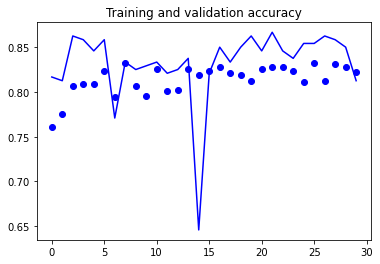

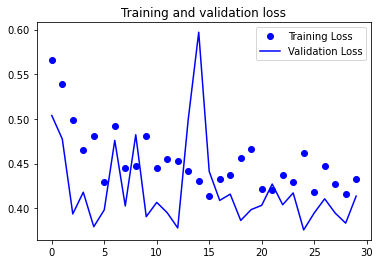

In [32]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# data_augmentation = Sequential(
#     [
#         Resizing(height=32, width=32,),
#         RandomFlip(mode="horizontal_and_vertical"),
#         RandomRotation(0.2),
#         RandomContrast(factor=0.1,),
#     ]
# )